# Identification of organic compounds from their refractive index using deep learning

---

This notebook is for a model developed using IR region data only


In [38]:
# Install keras
# !pip install keras==2.1.6

In [39]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

In [40]:
# Mounting google drive, to be able to write & read files on it
# This code block can only run on colab.research.google.com (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing our scrapped data, currently using github hosted file.
This data is a result of web scrapping "refractiveindex.info" website


In [41]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/riScrappedData.csv")
df.head()

,book,wl,n,k
0,CH4 (Methane),1.68,1.000436,NaN
1,CH4 (Methane),1.94,1.000436,NaN
2,CH4 (Methane),2.67,1.000433,NaN
3,CH4 (Methane),2.79,1.000431,NaN
4,CH4 (Methane),2.96,1.000428,NaN


# Data visualization and pre-processing

## Handling missing values

In [42]:
# Shape of the dataframe
df.shape

(248756, 4)

In [43]:
# Counting null values from each column
df.isna().sum()

book       0
wl         0
n          0
k       9645
dtype: int64

There are 9645 missing values of K

In [44]:
# Replacing all missing values of K with zero
df['k'].fillna(0, inplace = True)

In [45]:
# Confirming we have handled NUll k values
df.isna().sum()

book    0
wl      0
n       0
k       0
dtype: int64

## One hot encoding targets (Classes of organic compounds) with integers

In [46]:
# Get unique values of classes, sort them to ensure always the same order

# encode class values as integers
encoder = LabelEncoder()
df['book'] = encoder.fit_transform(df['book'])

# This is our dictionary for decoding the labels 
# (Same order as indices of probabilities from NN prediction)
classes_dictionary = dict(zip(encoder.transform(encoder.classes_), encoder.classes_,))
classes_dictionary = str(classes_dictionary) 

# Write our dictionary to a json file
import json
	
# Write to current runtime
with open("classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

# Write to google drive
with open("/content/drive/MyDrive/colab_data/DLOrganicClassifierData/classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

## Grouping data by wavelengths
i.e 'UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'

In [47]:
# Shuffling data to make it random
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,45,1.29674,1.47459,0.000009
1,42,3.32073,1.49087,0.004716
2,18,3.76908,1.33300,0.000187
3,33,4.07171,1.49049,0.000604
4,42,2.29922,1.47704,0.000030


In [48]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_range
59231,18,6.16016,1.32645,0.001050,Far_IR
38387,22,9.83923,1.47583,0.017851,Far_IR
34094,18,1.63125,1.33365,0.000004,IR


Let’s see how many of each class is in our data set

In [49]:
df['wl_range'].value_counts()

IR         129252
Far_IR      73576
Near_IR     37853
Visible      6268
UV           1807
Name: wl_range, dtype: int64

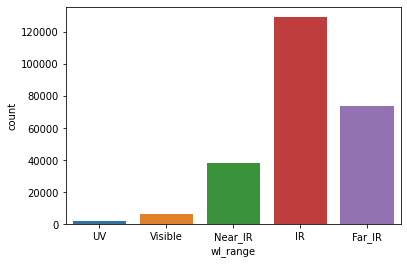

In [50]:
# Visualising
sns.countplot(x ='wl_range', data = df)

In [51]:
# Lets select only rows within IR
df = df.loc[df['wl_range'].isin(['IR'])]
df.head()

,book,wl,n,k,wl_range
1,42,3.32073,1.49087,0.004716,IR
2,18,3.76908,1.33300,0.000187,IR
4,42,2.29922,1.47704,0.000030,IR
5,33,2.11000,1.48773,0.000026,IR
7,41,3.25553,1.52071,0.008551,IR


In [52]:
# Describe new df with only Infrared data
df.describe()

,book,wl,n,k
count,129252.000000,129252.000000,129252.000000,129252.000000
mean,35.460349,2.377805,1.436876,0.003031
std,12.872896,0.684842,0.080488,0.012337
min,0.000000,1.500030,1.000426,0.000000
25%,28.000000,1.789710,1.361430,0.000034
50%,40.000000,2.212400,1.428240,0.000102
75%,46.000000,2.865970,1.515560,0.000395
max,59.000000,4.000000,1.654430,0.261700


In [53]:
df.shape

(129252, 5)

## Feature selection/extraction
Creating predictors(X) and Targets(y) for Training and testing the Deep Learning model.

In [54]:
# Predictors / Features (X)
x = df.drop(['book', 'wl_range'], axis=1)

# Target (y)
y = df['book']   # Taget Vector

print('Shapes of Predictors & Targets')

print('Predictors (X): ', np.shape(x))
print('Targets (y): ', np.shape(y))

Shapes of Predictors & Targets
Predictors (X):  (129252, 3)
Targets (y):  (129252,)


## Normalizing Data


In [55]:
x_norm = (x - x.mean()) / x.std()
x_norm.sample(10)

,wl,n,k
32969,0.454594,0.450302,-0.237030
48707,-1.130852,1.371931,-0.245475
159101,-0.410365,-0.982461,-0.225934
220089,-1.217106,-1.281760,-0.245639
135571,-0.658846,-1.140124,-0.243890
102397,-0.639221,0.981313,-0.242788
153012,-1.208753,-0.611100,-0.245206
167036,-0.007995,-1.285736,-0.239443
16331,0.536189,0.604859,-0.224180
184649,1.249843,1.258249,0.046964


# Train - Test data splitting 
`80%` for training and `20%` for testing



In [56]:
# split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2,random_state=42)

In [57]:
print ('X - Train shape: ', x_train.shape)
print ('y - Train shape: ', y_train.shape)

print ('X - Test shape: ', x_test.shape)
print ('y - Test shape: ', y_test.shape)

X - Train shape:  (103401, 3)
y - Train shape:  (103401,)
X - Test shape:  (25851, 3)
y - Test shape:  (25851,)


In [58]:
# Converting our target into categorical
# (one hot encode outputs)
# The output of each prediction will be the 60 probalilities of corresponding 
# classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
print('There are ',num_classes, ' classes of organic compounds')

There are  60  classes of organic compounds


## Building our deep learning model using tensorflow and keras

In [65]:
# Building DL Classifier
# define classification model
def classification_model():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=(3,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
 
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# build the model
model = classification_model()
epochs = 150

In [66]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                200       
                                                                 
 dense_4 (Dense)             (None, 100)               5100      
                                                                 
 dense_5 (Dense)             (None, 60)                6060      
                                                                 
Total params: 11,360
Trainable params: 11,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train, validate & test
# We are removing 30% of data from training set as Validation set
# & Fitting the model (Training)
history = model.fit(x_train, y_train, validation_split = 0.3, epochs = epochs, verbose=2)

Epoch 1/150
2262/2262 - 5s - loss: 1.0822 - accuracy: 0.6601 - val_loss: 0.6890 - val_accuracy: 0.7596 - 5s/epoch - 2ms/step
Epoch 2/150
2262/2262 - 4s - loss: 0.5192 - accuracy: 0.8592 - val_loss: 0.4294 - val_accuracy: 0.8783 - 4s/epoch - 2ms/step
Epoch 3/150
2262/2262 - 5s - loss: 0.3822 - accuracy: 0.8931 - val_loss: 0.3436 - val_accuracy: 0.8971 - 5s/epoch - 2ms/step
Epoch 4/150
2262/2262 - 4s - loss: 0.3223 - accuracy: 0.9027 - val_loss: 0.3044 - val_accuracy: 0.9071 - 4s/epoch - 2ms/step
Epoch 5/150
2262/2262 - 4s - loss: 0.2882 - accuracy: 0.9092 - val_loss: 0.2883 - val_accuracy: 0.9118 - 4s/epoch - 2ms/step
Epoch 6/150
2262/2262 - 4s - loss: 0.2647 - accuracy: 0.9153 - val_loss: 0.2647 - val_accuracy: 0.9194 - 4s/epoch - 2ms/step
Epoch 7/150
2262/2262 - 4s - loss: 0.2497 - accuracy: 0.9181 - val_loss: 0.2522 - val_accuracy: 0.9220 - 4s/epoch - 2ms/step
Epoch 8/150
2262/2262 - 4s - loss: 0.2349 - accuracy: 0.9229 - val_loss: 0.2368 - val_accuracy: 0.9226 - 4s/epoch - 2ms/step


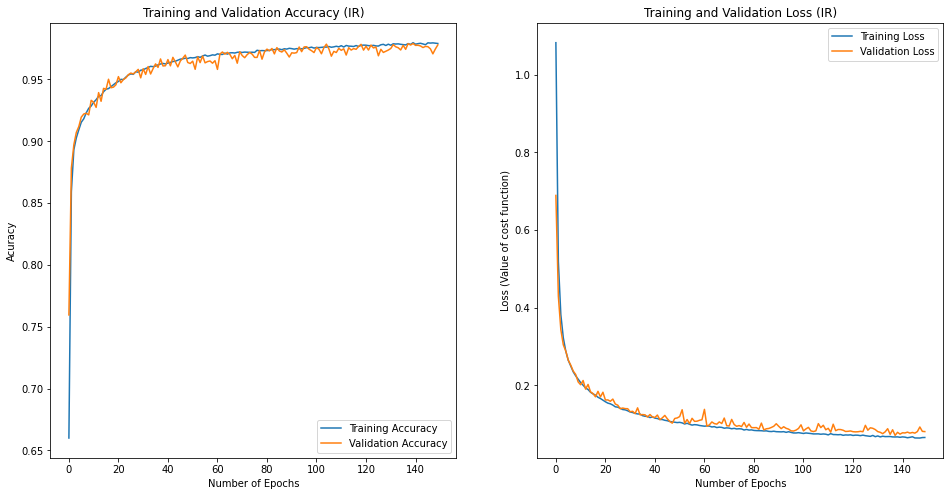

In [74]:
# Visualizing results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (IR)')
plt.ylabel('Acuracy')
plt.xlabel('Number of Epochs')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (IR)')
plt.ylabel('Loss (Value of cost function)')
plt.xlabel('Number of Epochs')
plt.show()

In [70]:
# # Save model as h5 (keras model)
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/IR_organic_model.h5')

In [71]:
# # Save the entire model as a SavedModel in drive
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/IR_organic_model') 

# Model Evaluation

In [72]:
# Model Accuracy
scores = model.evaluate(x_test, y_test, verbose=0)
print('The test Accuracy is: ', scores[1])
print('The test Loss is: ', scores[0])

The test Accuracy is:  0.977215588092804
The test Loss is:  0.07506441324949265


In [73]:
# Classification report
y_pred = model.predict(x_test) # Whole test set
classes = encoder.classes_.tolist() # Convert our array of labels (classes) to list

predicted_categories = np.argmax(y_pred, axis=1) 
true_categories_argmax = np.argmax(y_test, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names = classes, labels = range (60) ))

                                                  precision    recall  f1-score   support

    (C10H8O4)n (Polyethylene terephthalate, PET)       0.85      0.85      0.85        54
                 (C16H14O3)n (Polycarbonate, PC)       0.66      0.76      0.71        51
  (C2ClF3)n (Polychlorotrifluoroethylene, PCTFE)       0.00      0.00      0.00         0
             (C2H3Cl)n (Polyvinyl chloride, PVC)       0.90      0.79      0.84        48
          (C2H4)n (Polyethylene, PE, HDPE, LDPE)       0.77      0.53      0.62        19
               (C2H4O)n (Polyvinyl alcohol, PVA)       0.00      0.00      0.00         0
         (C2H6OSi)n (Polydimethylsiloxane, PDMS)       0.81      0.84      0.82       277
             (C37H24O6N2)n (Polyetherimide, PEI)       1.00      0.90      0.95        49
                (C3H4O2)n (Polylactic acid, PLA)       0.00      0.00      0.00         0
     (C5H8O2)n (Poly(methyl methacrylate), PMMA)       0.75      0.90      0.82       156
         